In [25]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import Window
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# files = glob('/app/data/*/*.csv')
# files

In [3]:
conf = SparkConf().setMaster("spark://spark-master:7077")\
                  .setAppName('Test') \
                  .set('spark.driver.memory', '2g')\
                  .set('spark.executor.memory', '5g')

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/27 10:55:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
schema = t.StructType([
    t.StructField('record_type', t.StringType()),
    t.StructField('type', t.StringType()),
    t.StructField('time', t.DoubleType()),
    t.StructField('project', t.StringType()),
    t.StructField('collector', t.StringType()),
    t.StructField('router', t.StringType()),
    t.StructField('router_ip', t.StringType()),
    t.StructField('peer_asn', t.IntegerType()),
    t.StructField('peer_address', t.StringType()),
    t.StructField('prefix', t.StringType()),
    t.StructField('next_hop', t.StringType()),
    t.StructField('as_path', t.StringType()),
    t.StructField('communities', t.StringType()),
])

df = spark.read.csv('/app/data/2024-07/1.csv', header=True, schema=schema)

In [10]:
df.show(10)

+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|record_type|type|               time|   project|       collector|router|router_ip|peer_asn|        peer_address|             prefix|            next_hop|             as_path|         communities|
+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:626b::/48|                NULL|                NULL|                NULL|
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:62c5::/48|                NULL|                NULL|                NULL|
|     update|  

In [11]:
start_time = dt.datetime(2024, 7, 7)
end_time = dt.datetime(2024, 7, 7, 4)

start_unixtime = start_time.timestamp()
end_unixtime = end_time.timestamp()

In [12]:
df_period = df.filter((df.time >= start_unixtime) & (df.time < end_unixtime))

In [13]:
@f.udf(returnType=t.ArrayType(t.StringType()))
def get_edges(as_path: str) -> list[str]:
    if not as_path:
        return None

    nodes = as_path.split(' ')
    edges = []
    for i in range(1, len(nodes)):
        node1 = nodes[i-1]
        node2 = nodes[i]
        if node1 != node2:
            edges.append(f'{node1}-{node2}')
        
    return edges

In [14]:
edges = df_period.select(
    f.explode(get_edges('as_path')).alias('edges')
).dropDuplicates(['edges']).toPandas()['edges']

In [16]:
edges

0           6939-25091
1          15412-23930
2           2914-32098
3          7303-265879
4           3356-29169
             ...      
48040       6939-17922
48041    263769-265848
48042     20485-139089
48043       3269-49215
48044       3356-61751
Name: edges, Length: 48045, dtype: object

In [15]:
edges.str.split('-').explode().drop_duplicates()

0          6939
0         25091
1         15412
1         23930
2          2914
          ...  
48020     58446
48021    135157
48024    139139
48029    150703
48041    265848
Name: edges, Length: 31333, dtype: object

In [53]:
import networkx as nx
import numpy as np
from sklearn.model_selection import ParameterGrid
from infomap import Infomap

im = Infomap(two_level=True, silent=True, num_trials=10)
im.add_networkx_graph(g)

grid = ParameterGrid({"markov_time": np.linspace(0.8, 3, 10)})

for params in grid:
    im.run(**params)
    print(
        f"markov_time={params['markov_time']:0.1f}: number of modules: {im.num_top_modules}"
    )

markov_time=0.8: number of modules: 2799
markov_time=1.0: number of modules: 2095
markov_time=1.3: number of modules: 1683
markov_time=1.5: number of modules: 1387
markov_time=1.8: number of modules: 1226
markov_time=2.0: number of modules: 1168
markov_time=2.3: number of modules: 670
markov_time=2.5: number of modules: 604
markov_time=2.8: number of modules: 563
markov_time=3.0: number of modules: 498


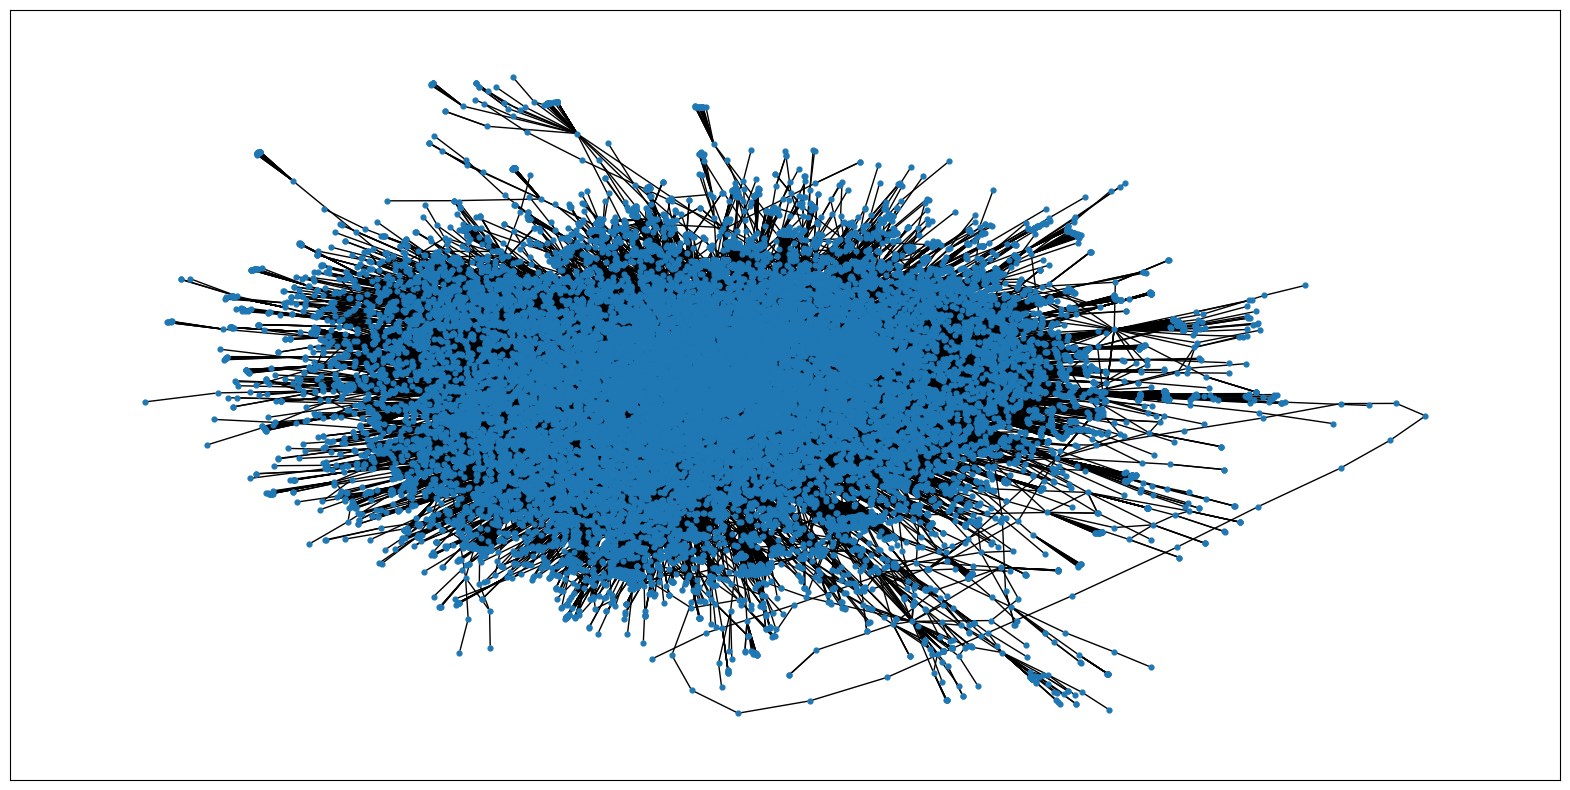

In [44]:
g = nx.Graph()

for edge in edges:
    node1, node2 = edge.split('-')
    g.add_edge(node1, node2)

plt.figure(figsize=(20, 10))
nx.draw_networkx(g, arrows=True, with_labels=False, node_size=12)

In [50]:
# spark.stop()